# Accessing Sentinel-2 Data from the Copernicus Data Space Ecosystem

This notebook demonstrates how to access and process Sentinel-2 satellite imagery from the Copernicus Data Space Ecosystem using both S3 and STAC interfaces.

### What you'll learn:
- How to connect to Copernicus Data Space Ecosystem using S3 credentials
- How to search for satellite imagery using STAC API
- How to download and visualize Sentinel-2 imagery
- How to process satellite images using Python

### Prerequisites:
- Copernicus Data Space Ecosystem account (https://dataspace.copernicus.eu/)
- Access and secret keys configured in environment variables

## Import dependencies

In [1]:
import io
import os
from urllib.parse import urlparse
import random


import boto3
import pystac_client
from dotenv import load_dotenv
from PIL import Image

## Setup and Environment Configuration

First, we'll import the required libraries and set up our environment. Make sure your Copernicus credentials are stored in your environment variables or a `.env` file.


In [2]:
# Get credentials from environment variables
load_dotenv()
ACCESS_KEY_ID = os.environ.get("ACCESS_KEY_ID")
SECRET_ACCESS_KEY = os.environ.get("SECRET_ACCESS_KEY")

## The S3Connector Class

The `S3Connector` class provides an interface to connect to the S3-compatible storage service of the Copernicus Data Space Ecosystem. This class handles authentication and connection management.


In [3]:
class S3Connector:
    """A clean connector for S3-compatible storage services"""

    def __init__(self, endpoint_url, access_key_id,
                 secret_access_key, region_name='default'):
        """Initialize the S3Connector with connection parameters"""
        self.endpoint_url = endpoint_url
        self.access_key_id = access_key_id
        self.secret_access_key = secret_access_key
        self.region_name = region_name

        # Create session
        self.session = boto3.session.Session()

        # Initialize S3 resource
        self.s3 = self.session.resource(
            's3',
            endpoint_url=self.endpoint_url,
            aws_access_key_id=self.access_key_id,
            aws_secret_access_key=self.secret_access_key,
            region_name=self.region_name
        )

        # Initialize S3 client
        self.s3_client = self.session.client(
            's3',
            endpoint_url=self.endpoint_url,
            aws_access_key_id=self.access_key_id,
            aws_secret_access_key=self.secret_access_key,
            region_name=self.region_name
        )

    def get_s3_client(self):
        """Get the boto3 S3 client"""
        return self.s3_client

    def get_s3_resource(self):
        """Get the boto3 S3 resource"""
        return self.s3

    def get_bucket(self, bucket_name):
        """Get a specific bucket by name"""
        return self.s3.Bucket(bucket_name)

    def list_buckets(self):
        """List all available buckets"""
        response = self.s3_client.list_buckets()
        if 'Buckets' in response:
            return [bucket['Name'] for bucket in response['Buckets']]
        return []

## Utility Functions

The following function helps convert S3 URIs from the STAC catalog into S3 keys that can be used for direct access.


In [4]:
def extract_s3_path_from_url(url):
    """
    Extracts the S3 object path from an S3 URL or URI.

    This function parses S3 URLs/URIs and returns just the object path portion,
    removing the protocol (s3://), bucket name, and any leading slashes.

    Args:
        url (str): The full S3 URI (e.g., 's3://eodata/path/to/file.jp2')

    Returns:
        str: The S3 object path (without protocol, bucket name and leading slashes)
    """
    # If it's not an S3 URI, return it unchanged
    if not url.startswith('s3://'):
        return url

    # Parse the S3 URI
    parsed_url = urlparse(url)

    # Ensure this is an S3 URL
    if parsed_url.scheme != 's3':
        raise ValueError(f"URL {url} is not an S3 URL")

    # Extract the path without leading slashes
    object_path = parsed_url.path.lstrip('/')

    return object_path

## The ProductDownloader Class

This class provides methods to download and handle Sentinel-2 images. It offers two primary ways to obtain imagery:
1. `get_product()`: Returns image content as bytes (useful for direct processing)
2. `get_product_content()`: Saves the image to a file on disk

In [5]:
def get_product(s3_resource, bucket_name, object_url, output_path):
    """
    Download a product from S3 bucket and create output directory if it doesn't exist.

    Args:
        s3_resource: boto3 S3 resource object
        bucket_name (str): Name of the S3 bucket
        object_url (str): Path to the object within the bucket
        output_path (str): Local directory to save the file

    Returns:
        str: Path to the downloaded file
    """
    # Create output directory if it doesn't exist
    os.makedirs(output_path, exist_ok=True)

    # Extract filename from the object URL
    _, filename = os.path.split(object_url)

    # Full path where the file will be saved
    local_file_path = os.path.join(output_path, filename)

    print(f"Downloading {object_url} to {local_file_path}...")

    try:
        # Download the file from S3
        s3_resource.Bucket(bucket_name).download_file(object_url, local_file_path)
        print(f"Successfully downloaded to {local_file_path}")
    except Exception as e:
        print(f"Error downloading file: {str(e)}")
        raise

    return local_file_path


def get_product_content(s3_client, bucket_name, object_url):
    """
    Download the content of a product from S3 bucket.

    Args:
        s3_client: boto3 S3 client object
        bucket_name (str): Name of the S3 bucket
        object_url (str): Path to the object within the bucket

    Returns:
        bytes: Content of the downloaded file
    """
    print(f"Downloading {object_url}...")

    try:
        # Download the file from S3
        response = s3_client.get_object(Bucket=bucket_name, Key=object_url)
        content = response['Body'].read()
        print(f"Successfully downloaded {object_url}")
    except Exception as e:
        print(f"Error downloading file: {str(e)}")
        raise

    return content

## Connecting to Copernicus Data Space Ecosystem

Now let's establish connections to both the S3 storage and STAC catalog services using our credentials.


In [6]:
ACCESS_KEY_ID = os.environ.get("ACCESS_KEY_ID")
SECRET_ACCESS_KEY = os.environ.get("SECRET_ACCESS_KEY")
ENDPOINT_URL = 'https://eodata.dataspace.copernicus.eu'
ENDPOINT_STAC = "https://stac.dataspace.copernicus.eu/v1/"

catalog = pystac_client.Client.open(ENDPOINT_STAC)
connector = S3Connector(
    endpoint_url=ENDPOINT_URL,
    access_key_id=ACCESS_KEY_ID,
    secret_access_key=SECRET_ACCESS_KEY,
    region_name='default'
)
# Get S3 client and resource from the connector instance
s3 = connector.get_s3_resource()
s3_client = connector.get_s3_client()
buckets = connector.list_buckets()
print("Available buckets:", buckets)

Available buckets: ['DIAS', 'EODATA']


## Searching for Sentinel-2 Product

We'll use the STAC API to search for Sentinel-2 Level 2A products based on:
- Geographic location (longitude/latitude point)
- Date range
- Cloud cover threshold

The search results provide metadata and access links to the actual imagery.


### Specific Area

In [13]:
LON, LAT = 150.97, -20.92


# Search for Sentinel-2 products
items_txt = catalog.search(
    collections=['sentinel-2-l2a'],
    intersects=dict(type="Point", coordinates=[LON, LAT]),
    datetime="2024-05-01/2024-06-01",
    query=["eo:cloud_cover<50"]
).item_collection()
selected_item = random.choice(items_txt)

In [14]:
items_txt[0]

<Item id=S2B_MSIL2A_20240526T001109_N0510_R073_T56KKB_20240526T013407>

### Boundinx Box

In [9]:
# Define bounding box coordinates [min_lon, min_lat, max_lon, max_lat]
min_lon, min_lat, max_lon, max_lat = 150.95,-20.92, 150.97, -20.95  # Example: 1° box around LON=15, LAT=50

# Create a bounding box polygon (must be closed, so repeat the first point at the end)
bbox_polygon = {
    "type": "Polygon",
    "coordinates": [[
        [min_lon, min_lat],  # Southwest corner
        [max_lon, min_lat],  # Southeast corner
        [max_lon, max_lat],  # Northeast corner
        [min_lon, max_lat],  # Northwest corner
        [min_lon, min_lat]   # Close the polygon by repeating the first point
    ]]
}

# Search for Sentinel-2 products within the bounding box
items_txt = catalog.search(
    collections=['sentinel-2-l2a'],
    intersects=bbox_polygon,
    datetime="2024-05-01/2024-06-01",
    query=["eo:cloud_cover<50"]
).item_collection()

In [10]:
items_txt

## Downloading Sentinel-2 Product

Once we've identified the imagery we want, we can download it using our S3 connection. We'll demonstrate both:
- Getting the image as bytes in memory
- Saving the image directly to disk


In [11]:
BUCKET_NAME = "eodata"
bucket = s3.Bucket(BUCKET_NAME)
selected_item = random.choice(items_txt)
product_url = extract_s3_path_from_url(selected_item.assets['TCI_60m'].href)
file_path = get_product(s3_resource=s3, bucket_name=BUCKET_NAME,
                             object_url=product_url,
                             output_path=".")
product_content = get_product_content(s3_client=s3_client, bucket_name=BUCKET_NAME,
                                     object_url=product_url)

Successfully downloaded to ./T56KKB_20240516T001109_TCI_60m.jp2
Successfully downloaded Sentinel-2/MSI/L2A/2024/05/16/S2B_MSIL2A_20240516T001109_N0510_R073_T56KKB_20240516T015827.SAFE/GRANULE/L2A_T56KKB_A037565_20240516T001108/IMG_DATA/R60m/T56KKB_20240516T001109_TCI_60m.jp2


## Visualizing the Downloaded Imagery

Now we can open and visualize the downloaded image using the Python Imaging Library (PIL).


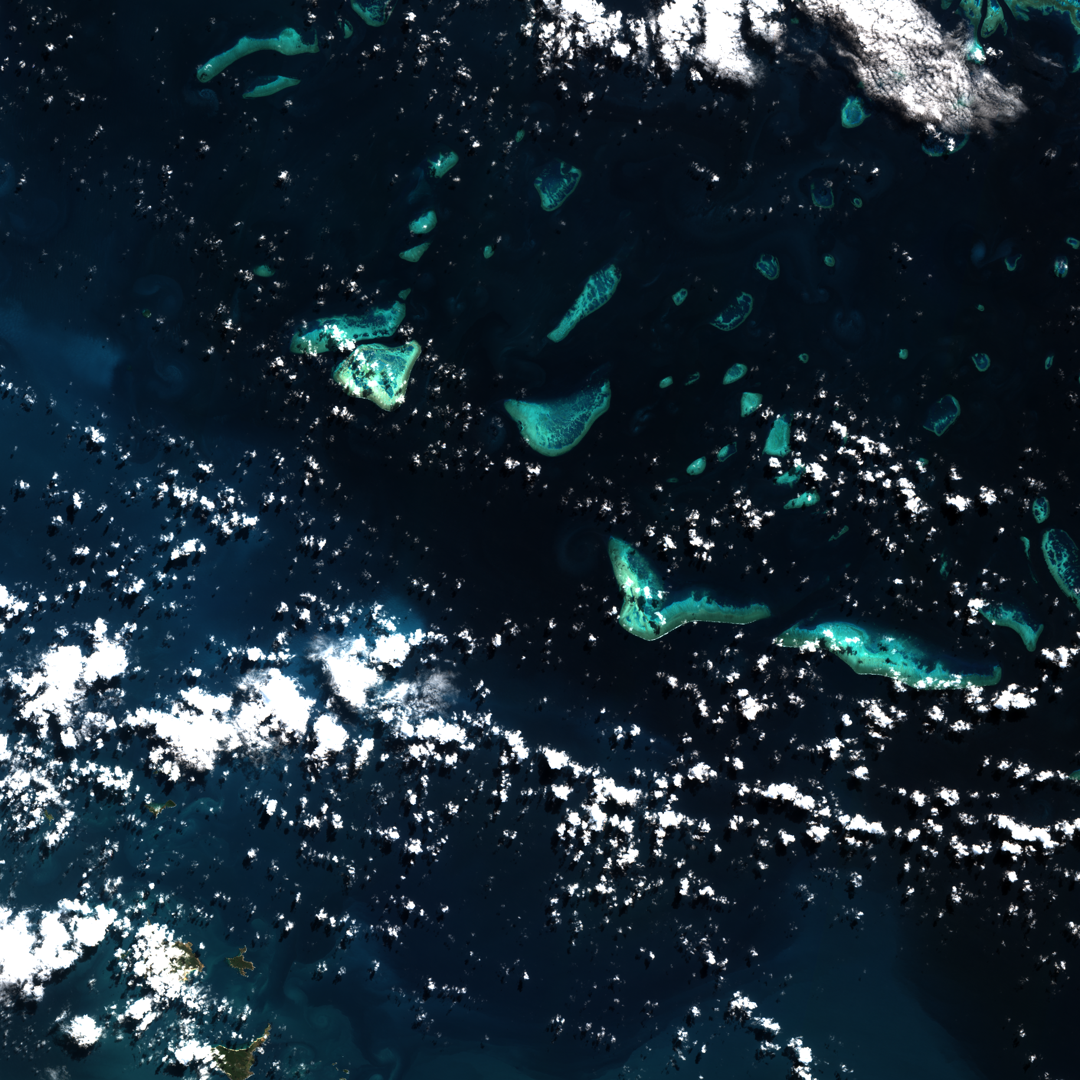

In [27]:
image = Image.open(io.BytesIO(product_content))
resized_image = image.resize((1080, 1080))
resized_image

In [ ]:
BUCKET_NAME = "eodata"
bucket = s3.Bucket(BUCKET_NAME)
selected_item = random.choice(items_txt)
product_url = extract_s3_path_from_url(selected_item.assets['TCI_60m'].href)
file_path = get_product(s3_resource=s3, bucket_name=BUCKET_NAME,
                             object_url=product_url,
                             output_path=".")
product_content = get_product_content(s3_client=s3_client, bucket_name=BUCKET_NAME,
                                     object_url=product_url)